## Principal components analysis with ETF 

The codes here are mostly based upon the sample provided by Pyquantnews.com.  Please see the original article here:
Source: https://www.pyquantnews.com/the-pyquant-newsletter/how-to-isolate-alpha-with-analysis

The goal of this notebook is to explore what observations can be obtained by replacing the single name stocks with ETFs that have different underlying asset classes.

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

The ETFs are as follow:

DAPP: VanEck Digital Transformation ETF (Blockchain focused equity)

DBA: Invesco DB Agriculture Fund (Agriculture)

DBO: Invesco DB Oil Fund (Crude Oil)

LVHI: Franklin Intl Low Volatility High Dividend Index

PIO: Invesco Global Water ETF

URA: Global X Uranium ETF

WIP: SPDR FTSE Intl Govt Inflation-Protected Bond ETF

XLP: Consumer Staples Select Sector SPDR Fund

For the most updated underlying and descriptions, please check each fund's current holding information, prospectus and quarterly reports.

The yfinance API is used to retrieve the price time series.  There is no need to create an API key like some of the other data services.

According to Wikipedia (https://en.wikipedia.org/wiki/Principal_component_analysis):

"Principal component analysis (PCA) is a linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.

The data is linearly transformed onto a new coordinate system such that the directions (principal components) capturing the largest variation in the data can be easily identifie"

The transformed variables can be thoughts of statistical variables and may not necessarily represent any real world onbserved variables.d.

In [6]:
# ETF symbols
ETF_symbols = [
    'DAPP',
    'DBA',
    'DBO',
    'LVHI',
    'PIO',
    'URA',
    'WIP',
    'XLP'
]

In [7]:
#retrive price data and calculate daily returns
etf_price_data = yf.download(ETF_symbols, start="2018-01-01")
etf_returns = etf_price_data['Adj Close'].pct_change().dropna()

etf_returns.head()

[*********************100%***********************]  8 of 8 completed


Ticker,DAPP,DBA,DBO,LVHI,PIO,URA,WIP,XLP
Date,,,,,,,,
2021-04-16 00:00:00+00:00,-0.016409,-0.002282,-0.001778,0.005662,0.009242,0.002070,-0.005132,0.005763
2021-04-19 00:00:00+00:00,-0.070507,0.003431,0.000890,0.001603,0.000262,-0.010847,0.008004,-0.003868
2021-04-20 00:00:00+00:00,-0.023366,0.011966,-0.014235,-0.011319,-0.003139,-0.014099,-0.002823,0.005465
2021-04-21 00:00:00+00:00,0.039182,0.004505,-0.017148,0.006317,0.005248,0.013771,0.000177,0.005005
2021-04-22 00:00:00+00:00,-0.053554,0.012332,0.009183,-0.002197,0.004437,-0.019331,-0.000354,-0.007400


Let's ask sklearn to return the top 5 components and fits the return time series

In [9]:
etf_pca = PCA(n_components=5)
etf_pca.fit(etf_returns)

PCA(n_components=5)

In [10]:
etf_pct = etf_pca.explained_variance_ratio_
etf_pca_components = etf_pca.components_

In [11]:
print(etf_pct)

[0.66375332 0.16862784 0.084347   0.03684014 0.02085399]


In [12]:
print(etf_pca_components)

[[-0.9367731  -0.02823043 -0.06534872 -0.06051262 -0.1299916  -0.30377425
  -0.05149204 -0.04357664]
 [ 0.32011794 -0.11562242 -0.47951384 -0.07647541 -0.10553479 -0.79344731
  -0.06390382 -0.05995022]
 [-0.11089995 -0.13133114 -0.85652799  0.04046607  0.11935008  0.46502513
   0.0341565   0.0592971 ]
 [-0.08165752 -0.02051627  0.04191193  0.32079792  0.69884517 -0.2413336
   0.30329704  0.49962751]
 [ 0.00522877 -0.98137213  0.17261957  0.00737683  0.01099112  0.04497194
  -0.06913142 -0.01034553]]


(0.0, 100.0)

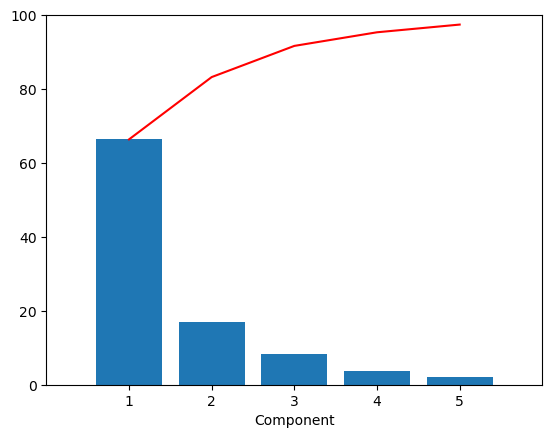

In [13]:
etf_cumu_pct = np.cumsum(etf_pct)
x = np.arange(1,len(etf_pct)+1,1) # +1 adjusted for start value = 1 (refer to first component)

plt.plot(x, etf_cumu_pct * 100, 'r', label = 'Cumulative contribution of PCA component(%)')
plt.bar(x, etf_pct * 100, label = 'Individual contribution of PCA component(%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 6])
plt.ylim([0, 100])

The top 5 components account for 97% of the explained variance.

To further analyze the ETF returns with the PCA:

1) The ETF returns dataframe is converted to an array
2) Transpose the PCA components via .T to prepare for dot cross multiplication
3) The .dot (dot cross multiplication) yields a table that provides how each component is contributed to each day's returns.


In [16]:
etf_returns_array = np.asarray(etf_returns)

etf_factor_returns = etf_returns_array.dot(etf_pca_components.T)

etf_factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3", "f4", "f5"], 
    index=etf_returns.index,
    data=etf_factor_returns
)

etf_factor_returns

,f1,f2,f3,f4,f5
Date,,,,,
2021-04-16 00:00:00+00:00,0.013392,-0.007205,0.006103,0.010410,0.002378
2021-04-19 00:00:00+00:00,0.068814,-0.015217,0.001702,0.009534,-0.004568
2021-04-20 00:00:00+00:00,0.027764,0.010199,0.006051,0.000518,-0.014936
2021-04-21 00:00:00+00:00,-0.041186,0.007970,0.017340,0.000914,-0.006516
2021-04-22 00:00:00+00:00,0.054988,-0.007468,-0.012545,0.007762,-0.011533
...,...,...,...,...,...
2024-09-03 00:00:00+00:00,0.106189,0.045223,0.009466,0.004802,-0.001378
2024-09-04 00:00:00+00:00,0.000990,-0.000088,0.021555,-0.010422,0.011936
2024-09-05 00:00:00+00:00,-0.025236,0.021314,-0.018175,0.006563,-0.007700


Text(0.5, 1.0, 'Factor 02 exposure')

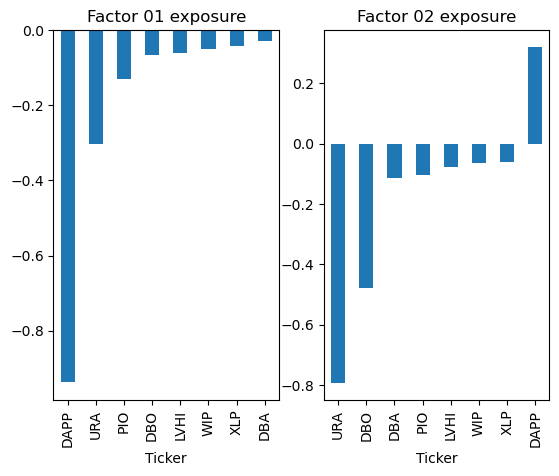

In [17]:
etf_factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3", "f4", "f5"], 
    columns=etf_returns.columns,
    data = etf_pca_components
).T

ax1 = plt.subplot(1, 2, 1)
etf_factor_exposures.f1.sort_values().plot.bar()
ax1.set_title(label='Factor 01 exposure')
ax2 = plt.subplot(1, 2, 2)
etf_factor_exposures.f2.sort_values().plot.bar()
ax2.set_title(label='Factor 02 exposure')

Text(0.5, 1.0, 'Factor 05 exposure')

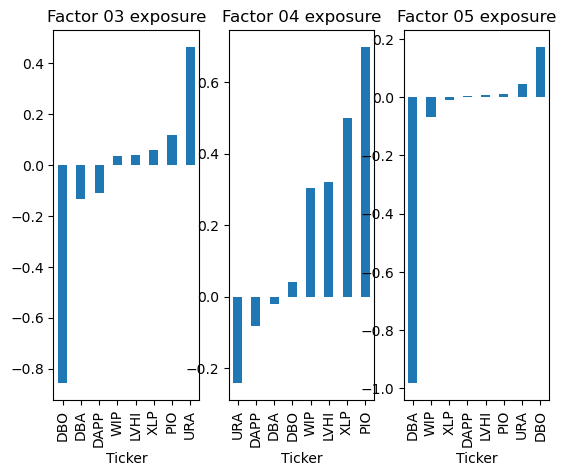

In [18]:
ax3 = plt.subplot(1, 3, 1)
etf_factor_exposures.f3.sort_values().plot.bar()
ax3.set_title(label='Factor 03 exposure')
ax4 = plt.subplot(1, 3, 2)
etf_factor_exposures.f4.sort_values().plot.bar()
ax4.set_title(label='Factor 04 exposure')
ax5 = plt.subplot(1, 3, 3)
etf_factor_exposures.f5.sort_values().plot.bar()
ax5.set_title(label='Factor 05 exposure')

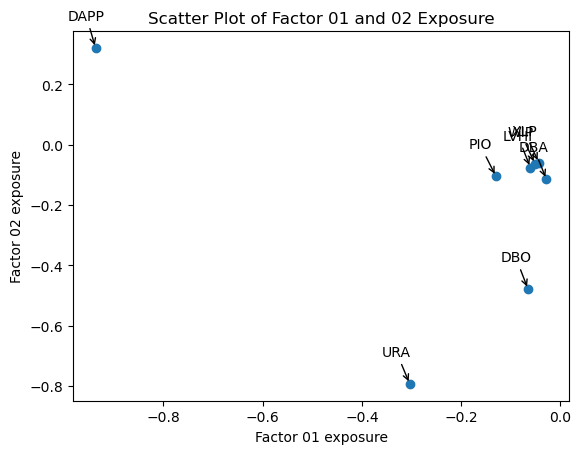

In [19]:
scatter_labels = etf_factor_exposures.index
scatter_data = etf_factor_exposures.values
plt.scatter(scatter_data[:, 0], scatter_data[:, 1])
plt.xlabel('Factor 01 exposure')
plt.ylabel('Factor 02 exposure')
plt.title('Scatter Plot of Factor 01 and 02 Exposure')

#add label of each ETF ticker.  ZIP is to allow iterable object to be join together
for label, x, y in zip(scatter_labels, scatter_data[:, 0], scatter_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-20, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )

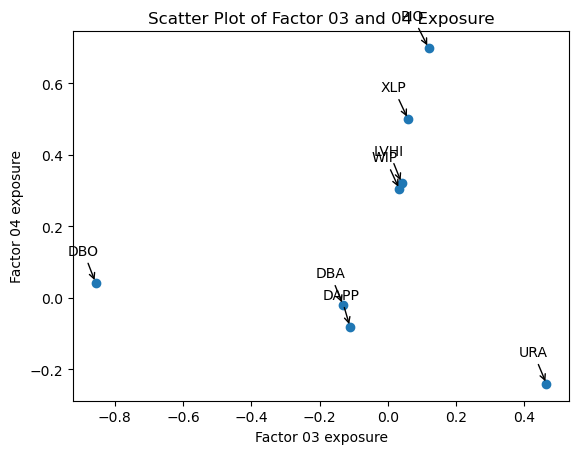

In [20]:
plt.scatter(scatter_data[:, 2], scatter_data[:, 3])
plt.xlabel('Factor 03 exposure')
plt.ylabel('Factor 04 exposure')
plt.title('Scatter Plot of Factor 03 and 04 Exposure')

#add label of each ETF ticker.  ZIP is to allow iterable object to be join together
for label, x, y in zip(scatter_labels, scatter_data[:, 2], scatter_data[:, 3]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-20, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )

Interestingly, these results are consistent with market observaitons. DAPP is relatively new ETF and it is focused on companies that have blockchain based business models.  The blockchain sector has been hot as Bitcoin has shown increase in values in the past decades.  However, DAPP's holdings haven't been doing too well and have exhibited downtrend from 2018 to 2024, while the rest of ETFs generally have price gains in post-pandemic enviornment.  This explains why DAPP has different directional and magniture exposures in the first scatter plot.  

URA exposure is a bit different as well so interest in Uraninum commodity investment became more prevalent in the investment community in 2023 and 2024.  Then there is DBO (oil) which is a bit shifted from the rest as it is more commodity based.

One relatively unexpected result is that the government inflation-protection bond fund (WIP) has very similar epxosures to equity ETFs to the first 2 factors.  It also has very similar factor exposures to factor 3 and 4 with LVHI (which is a high dividend and low volatility equity ETF).  This is likely because of the relatively low risk nature of these two funds.